---
## **Importing Libraries and Database**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import sqlite3
import warnings
import datetime

In [2]:
df = pd.read_csv("/kaggle/input/ecommerce-data/data.csv",encoding = "latin1")
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

---
## **Data Cleaning and Preprocessing**


In [3]:
df.fillna({"Description": "Unknown"}, inplace = True)
df.dropna(subset=["CustomerID"], inplace=True)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["CustomerID"] = df["CustomerID"].astype("Int64")
warnings.filterwarnings("ignore", category=FutureWarning)
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  Int64         
 7   Country      406829 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 28.3+ MB


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

---
## **Connecting Database**


In [4]:
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()
df.to_sql("ecommerce",conn,index=False,if_exists="replace")

406829

---
## **Customer Behaviour Analysis**


- ### Top 5 Customers Based on Spending

 CustomerID  TotalSpent
      14646   279489.02
      18102   256438.49
      17450   187482.17
      14911   132572.62
      12415   123725.45


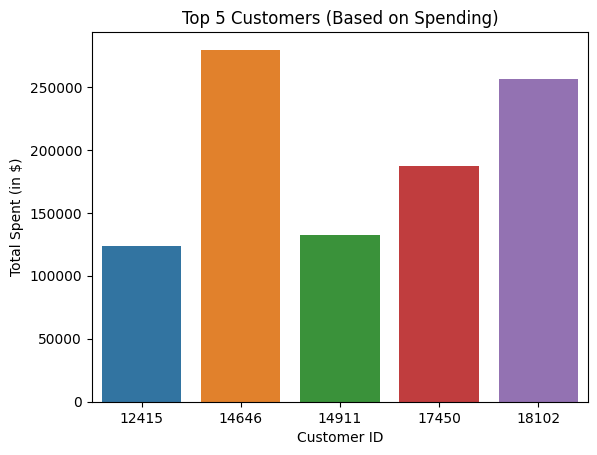

In [5]:
squery = "SELECT CustomerID, SUM(Quantity * UnitPrice) AS TotalSpent FROM ecommerce GROUP BY CustomerID ORDER BY TotalSpent DESC LIMIT 5;"
top_cust = pd.read_sql_query(squery, conn)
print(top_cust.to_string(index=False))
sns.barplot(x="CustomerID",y="TotalSpent",data=top_cust)
plt.title("Top 5 Customers (Based on Spending)")
plt.xlabel("Customer ID")
plt.ylabel("Total Spent (in $)")
plt.show()

---
- ### Top 5 Selling Products

                       Description  TotalQuantity
 WORLD WAR 2 GLIDERS ASSTD DESIGNS          53215
           JUMBO BAG RED RETROSPOT          45066
     ASSORTED COLOUR BIRD ORNAMENT          35314
WHITE HANGING HEART T-LIGHT HOLDER          34147
   PACK OF 72 RETROSPOT CAKE CASES          33409


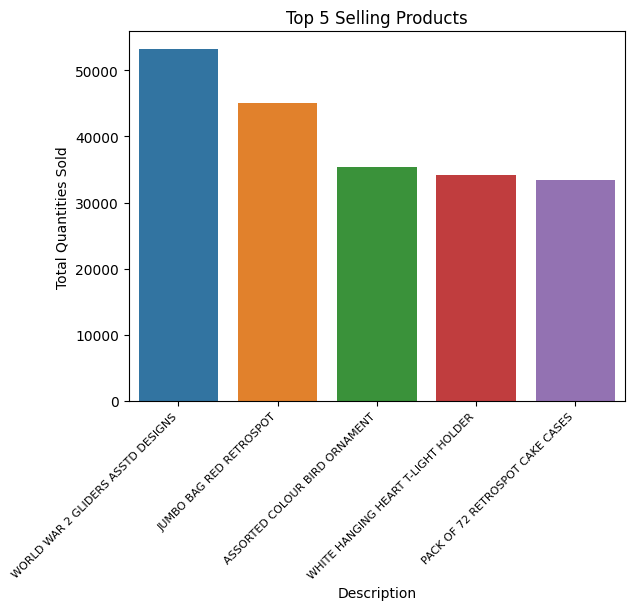

In [6]:
squery = "SELECT Description, SUM(Quantity) AS TotalQuantity FROM ecommerce GROUP BY Description ORDER BY TotalQuantity DESC LIMIT 5;"
hot_items = pd.read_sql_query(squery, conn)
print(hot_items.to_string(index=False))
sns.barplot(x="Description",y="TotalQuantity",data=hot_items)
plt.title("Top 5 Selling Products")
plt.xlabel("Description")
plt.xticks(fontsize=8,rotation=45,ha="right")
plt.ylabel("Total Quantities Sold")
plt.show()

---
- ### Top 10 Loyal Customers

 CustomerID  Frequency
      14911        248
      12748        224
      17841        169
      14606        128
      15311        118
      13089        118
      12971         89
      14527         86
      13408         81
      14646         77


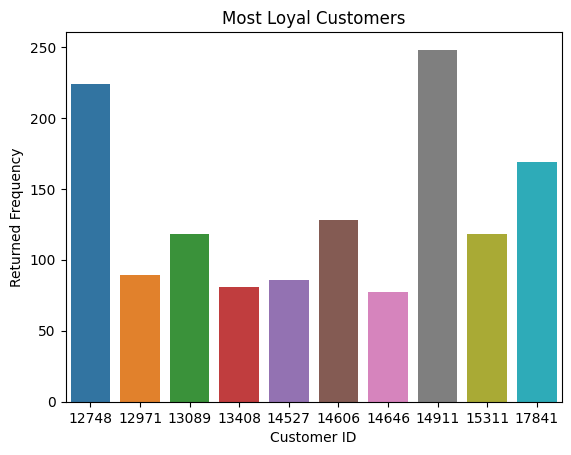

In [7]:
query = """
SELECT CustomerID, COUNT(DISTINCT InvoiceNo) AS Frequency
FROM ecommerce
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID
ORDER BY Frequency DESC;
"""
rfm = pd.read_sql_query(query, conn)
loyal_customers = rfm.head(10)
print(loyal_customers[["CustomerID","Frequency"]].to_string(index=False))
sns.barplot(x="CustomerID",y="Frequency",data=loyal_customers)
plt.title("Most Loyal Customers")
plt.xlabel("Customer ID")
plt.ylabel("Returned Frequency")
plt.show()

---
- ### Monthly Sales Trends

  Month     Revenue
2011-01  475074.380
2011-02  436546.150
2011-03  579964.610
2011-04  426047.851
2011-05  648251.080
2011-06  608013.160
2011-07  574238.481
2011-08  616368.000
2011-09  931440.372
2011-10  974603.590
2011-11 1132407.740
2011-12  342506.380


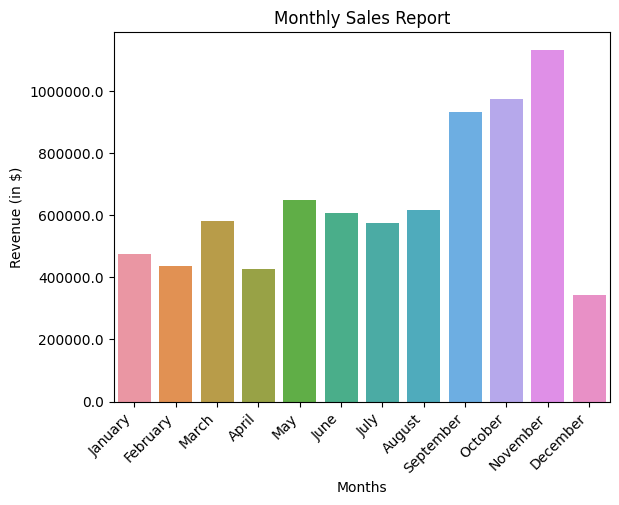

In [8]:
squery = "SELECT strftime('%Y-%m', InvoiceDate) AS Month, SUM(Quantity * UnitPrice) AS Revenue FROM ecommerce WHERE InvoiceDate >= '2011-01-01' GROUP BY Month ORDER BY Month;"
monthly_sales = pd.read_sql_query(squery,conn)
print(monthly_sales.to_string(index=False))
months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
sns.barplot(x="Month",y="Revenue",data=monthly_sales)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y*1}'))
plt.title("Monthly Sales Report")
plt.xlabel("Months")
plt.ylabel("Revenue (in $)")
plt.xticks(ticks=range(len(months)),labels=months,rotation=45,ha="right")
plt.show()